# Performance

This notebook is intended to demonstrate the performance of AlphaTims.
It contains the following information:
1. [**Samples**](#Samples)
2. [**Reading raw Bruker .d folders**](#Reading-raw-Bruker-.d-folders)
3. [**Saving HDF files**](#Saving-HDF-files)
4. [**Reading HDF files**](#Reading-HDF-files)
5. [**Slicing data**](#Slicing-data)
6. [**Final overview**](#Final-overview)

The following system was used:

In [1]:
import alphatims.utils
import pandas as pd
import numpy as np

alphatims.utils.set_threads(8)
log_file_name = alphatims.utils.set_logger(
    log_file_name="performance_log.txt",
    overwrite=True
)
alphatims.utils.show_platform_info()
alphatims.utils.show_python_info()
alphatims.utils.set_progress_callback(None)

2021-09-22 09:32:13> Platform information:
2021-09-22 09:32:13> system        - Darwin
2021-09-22 09:32:13> release       - 19.6.0
2021-09-22 09:32:13> version       - 10.15.7
2021-09-22 09:32:13> machine       - x86_64
2021-09-22 09:32:13> processor     - i386
2021-09-22 09:32:13> cpu count     - 8
2021-09-22 09:32:13> cpu frequency - 2300.00 Mhz
2021-09-22 09:32:13> ram           - 18.9/32.0 Gb (available/total)
2021-09-22 09:32:13> 
2021-09-22 09:32:13> Python information:
2021-09-22 09:32:13> alphatims  - 0.3.0
2021-09-22 09:32:13> bokeh      - 2.2.3
2021-09-22 09:32:13> click      - 8.0.1
2021-09-22 09:32:13> datashader - 0.12.1
2021-09-22 09:32:13> h5py       - 3.2.1
2021-09-22 09:32:13> hvplot     - 0.7.1
2021-09-22 09:32:13> numba      - 0.53.1
2021-09-22 09:32:13> pandas     - 1.2.4
2021-09-22 09:32:13> psutil     - 5.8.0
2021-09-22 09:32:13> python     - 3.8.10
2021-09-22 09:32:13> python-lzf - 0.2.4
2021-09-22 09:32:13> pyzstd     - 0.15.0
2021-09-22 09:32:13> selenium   - 3

## Samples

Six samples (https://www.ebi.ac.uk/pride/archive/projects/PXD027359) are used and compared:

In [2]:
file_names = {
    "DDA_6": "/Users/swillems/Data/alphatims_testing/20210510_TIMS03_EVO03_PaSk_MA_HeLa_50ng_5_6min_DDA_S1-B1_1_25185.d",
    "DIA_6": "/Users/swillems/Data/alphatims_testing/20210510_TIMS03_EVO03_PaSk_SA_HeLa_50ng_5_6min_DIA_high_speed_S1-B2_1_25186.d",
    "DDA_21": "/Users/swillems/Data/alphatims_testing/20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_DDA_21min_8cm_S1-C10_1_22476.d",
    "DIA_21": "/Users/swillems/Data/alphatims_testing/20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_high_speed_21min_8cm_S1-C8_1_22474.d",
    "DDA_120": "/Users/swillems/Data/alphatims_testing/20210507_TIMS01_LC01_PaSk_MA_HeLa_400ng_ddaAPSEF_A1_1_7545.d",
    "DIA_120": "/Users/swillems/Data/alphatims_testing/20210507_TIMS01_LC01_PaSk_SA_HeLa_400ng_diaPASEF_high_speed_A1_1_7546.d",
}
overview = pd.DataFrame(index=file_names.keys())
overview["Type"] = pd.Series({x: x.split("_")[0] for x in file_names})
overview["Gradient (min)"] = pd.Series({x: x.split("_")[1] for x in file_names})

We first load all these files to show their basic statistics before we do the actual timing:

In [3]:
import logging
import alphatims.bruker

timstof_objects = {}
detector_events = {}
for sample_id, file_name in file_names.items():
    logging.info(f"Initial loading of {sample_id}")
    timstof_objects[sample_id] = alphatims.bruker.TimsTOF(file_name)
    detector_events[sample_id] = len(timstof_objects[sample_id])
    logging.info("")
overview["Detector events"] = pd.Series(detector_events)

2021-09-22 09:32:13> WARNING: No Bruker libraries are available for this operating system. Intensities are uncalibrated, resulting in (very) small differences. However, mobility and m/z values need to be estimated. While this estimation often returns acceptable results with errors < 0.02 Th, huge errors (e.g. offsets of 6 Th) have already been observed for some samples!
2021-09-22 09:32:13> 
2021-09-22 09:32:14> Initial loading of DDA_6
2021-09-22 09:32:14> Importing data from /Users/swillems/Data/alphatims_testing/20210510_TIMS03_EVO03_PaSk_MA_HeLa_50ng_5_6min_DDA_S1-B1_1_25185.d
2021-09-22 09:32:14> Reading frame metadata for /Users/swillems/Data/alphatims_testing/20210510_TIMS03_EVO03_PaSk_MA_HeLa_50ng_5_6min_DDA_S1-B1_1_25185.d
2021-09-22 09:32:14> Reading 3,156 frames with 143,542,808 detector events for /Users/swillems/Data/alphatims_testing/20210510_TIMS03_EVO03_PaSk_MA_HeLa_50ng_5_6min_DDA_S1-B1_1_25185.d
2021-09-22 09:32:15> Indexing /Users/swillems/Data/alphatims_testing/2021

In summary, we thus consider the following samples:

In [4]:
overview.style.format({"Detector events": "{:,}"})

,Type,Gradient (min),Detector events
DDA_6,DDA,6,"143,542,808"
DIA_6,DIA,6,"126,982,956"
DDA_21,DDA,21,"295,251,252"
DIA_21,DIA,21,"730,564,765"
DDA_120,DDA,120,"2,736,188,777"
DIA_120,DIA,120,"6,364,599,982"


## Reading raw Bruker .d folders

To avoid unwanted system inferences, we perform a `timeit` function to get a robust estimate of loading times for raw Bruker .d folders:

In [5]:
alphatims.utils.set_logger(stream=False)
raw_load_times = {}
for sample_id, file_name in file_names.items():
    print(f"Time to load {sample_id} raw Bruker .d folder:")
    raw_load_time = %timeit -o tmp = alphatims.bruker.TimsTOF(file_name)
    raw_load_times[sample_id] = np.average(raw_load_time.timings)
    print("")
overview["Load .d (s)"] = pd.Series(raw_load_times)

Time to load DDA_6 raw Bruker .d folder:
1.26 s ± 81.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DIA_6 raw Bruker .d folder:
1.05 s ± 77.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DDA_21 raw Bruker .d folder:
3.21 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DIA_21 raw Bruker .d folder:
4.69 s ± 73.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DDA_120 raw Bruker .d folder:
29.9 s ± 2.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DIA_120 raw Bruker .d folder:
1min 29s ± 1.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



## Saving HDF files

Each of the data files can also be exported to HDF files:

In [6]:
save_hdf_times = {}
for sample_id, data in timstof_objects.items():
    print(f"Time to export {sample_id} to HDF file:")
    path = data.directory
    file_name = f"{data.sample_name}.hdf"
    save_hdf_time = %timeit -o tmp = data.save_as_hdf(path, file_name, overwrite=True)
    save_hdf_times[sample_id] = np.average(save_hdf_time.timings)
    print("")
overview["Save .hdf (s)"] = pd.Series(save_hdf_times)

Time to export DDA_6 to HDF file:
418 ms ± 83.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to export DIA_6 to HDF file:
350 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to export DDA_21 to HDF file:
956 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to export DIA_21 to HDF file:
1.93 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to export DDA_120 to HDF file:
6.77 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to export DIA_120 to HDF file:
3min 40s ± 5.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



## Reading HDF files

Once these HDF files are created, they can be loaded much faster than raw Bruker .d folders:

In [7]:
import os
load_hdf_times = {}
for sample_id, data in timstof_objects.items():
    print(f"Time to load {sample_id} HDF file:")
    file_name = os.path.join(data.directory, f"{data.sample_name}.hdf")
    load_hdf_time = %timeit -o tmp = alphatims.bruker.TimsTOF(file_name)
    load_hdf_times[sample_id] = np.average(load_hdf_time.timings)
    print("")
overview["Load .hdf (s)"] = pd.Series(load_hdf_times)

Time to load DDA_6 HDF file:
388 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DIA_6 HDF file:
167 ms ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DDA_21 HDF file:
993 ms ± 44.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DIA_21 HDF file:
2.6 s ± 538 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DDA_120 HDF file:
14.8 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to load DIA_120 HDF file:
35.6 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



## Slicing data

Lastly, we can slice this data. Since this uses Numba JIT compilation, we first compile the relevant functions with an initial slice call:

In [8]:
tmp = timstof_objects["DDA_6"][0]

Now we can time how long it takes to slice in different dimensions:
   * **LC:** $100.0 \leq \textrm{retention_time} \lt 100.5$
   * **TIMS:** $\textrm{scan_index} = 450$
   * **Quadrupole:** $700.0 \leq \textrm{quad_mz_values} \lt 710.0$
   * **TOF:** $621.9 \leq \textrm{tof_mz_values} \lt 622.1$

In [9]:
import os

frame_slice_times = {}
scan_slice_times = {}
quad_slice_times = {}
tof_slice_times = {}

frame_slice_counts = {}
scan_slice_counts = {}
quad_slice_counts = {}
tof_slice_counts = {}

for sample_id, data in timstof_objects.items():
    print(f"Time to slice {sample_id}:")
    
    count = len(data[100.:100.5, "raw"])
    print(
        f"Testing LC slice data[100.0: 100.5] ({count:,} detector hits)."
    )
    frame_slice_time = %timeit -o tmp = data[100.:100.5, "raw"]
    frame_slice_counts[sample_id] = count
    frame_slice_times[sample_id] = np.average(frame_slice_time.timings)
    
    count = len(data[:, 450, "raw"])
    print(
        f"Testing TIMS slice data[:, 450] ({count:,} detector hits)."
    )
    scan_slice_time = %timeit -o tmp = data[:, 450, "raw"]
    scan_slice_counts[sample_id] = count
    scan_slice_times[sample_id] = np.average(scan_slice_time.timings)
    
    count = len(data[:, :, 700.0: 710, "raw"])
    print(
        f"Testing QUAD slice data[:, :, 700.0: 710] ({count:,} detector hits)."
    )
    quad_slice_time = %timeit -o tmp = data[:, :, 700.0: 710, "raw"]
    quad_slice_counts[sample_id] = count
    quad_slice_times[sample_id] = np.average(quad_slice_time.timings)
    
    count = len(data[:, :, :, 621.9: 622.1, "raw"])
    print(
        f"Testing TOF slice data[:, :, :, 621.9: 622.1] ({count:,} detector hits)."
    )
    tof_slice_time = %timeit -o tmp = data[:, :, :, 621.9: 622.1, "raw"]
    tof_slice_counts[sample_id] = count
    tof_slice_times[sample_id] = np.average(tof_slice_time.timings)
    
    print("")
    
overview["Slice LC (s)"] = pd.Series(frame_slice_times)
overview["Slice LC (hits)"] = pd.Series(frame_slice_counts)
overview["Slice TIMS (s)"] = pd.Series(scan_slice_times)
overview["Slice TIMS (hits)"] = pd.Series(scan_slice_counts)
overview["Slice QUAD (s)"] = pd.Series(quad_slice_times)
overview["Slice QUAD (hits)"] = pd.Series(quad_slice_counts)
overview["Slice TOF (s)"] = pd.Series(tof_slice_times)
overview["Slice TOF (hits)"] = pd.Series(tof_slice_counts)

Time to slice DDA_6:
Testing LC slice data[100.0: 100.5] (124,835 detector hits).
4.01 ms ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing TIMS slice data[:, 450] (234,662 detector hits).
8.66 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing QUAD slice data[:, :, 700.0: 710] (40,583 detector hits).
12.4 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing TOF slice data[:, :, :, 621.9: 622.1] (38,471 detector hits).
72.6 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Time to slice DIA_6:
Testing LC slice data[100.0: 100.5] (59,714 detector hits).
1.94 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing TIMS slice data[:, 450] (162,369 detector hits).
6.78 ms ± 80.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing QUAD slice data[:, :, 700.0: 710] (4,173,952 detector hits).
158 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing TOF slice dat

## Final overview

The final time performance can thus be summarized as follows:

In [10]:
def format_df(overview):
    new_overview = pd.DataFrame()
    for column_name, dtype in zip(overview.columns, overview.dtypes):
        new_column = overview[column_name]
        if dtype == np.int64:
            new_column = new_column.apply(lambda z: f"{z:,}")
        elif dtype == np.float64:
            new_column = new_column.apply(lambda z: f"{z:#.3g}")
        new_overview[column_name] = new_column
    return new_overview.T

overview.T.to_csv("performance_results.csv")
format_df(overview)

,DDA_6,DIA_6,DDA_21,DIA_21,DDA_120,DIA_120
Type,DDA,DIA,DDA,DIA,DDA,DIA
Gradient (min),6,6,21,21,120,120
Detector events,"143,542,808","126,982,956","295,251,252","730,564,765","2,736,188,777","6,364,599,982"
Load .d (s),1.26,1.05,3.21,4.69,29.9,89.7
Save .hdf (s),0.418,0.350,0.956,1.93,6.77,220.
Load .hdf (s),0.388,0.167,0.993,2.60,14.8,35.6
Slice LC (s),0.00401,0.00194,0.000671,0.000237,0.000134,0.000985
Slice LC (hits),"124,835","59,714","20,923","5,098","2,185","29,248"
Slice TIMS (s),0.00866,0.00678,0.0291,0.0621,0.213,0.479
Slice TIMS (hits),"234,662","162,369","658,010","1,353,926","5,292,442","10,531,583"


Alternatively, it can be presented visually:

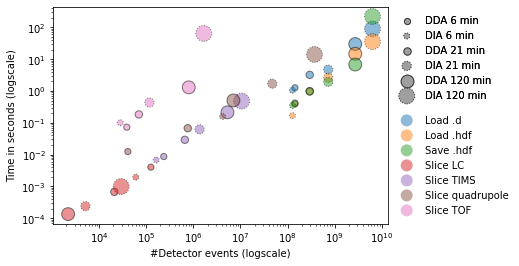

In [11]:
from matplotlib import pyplot as plt
sizes = np.sqrt(overview["Detector events"]/10**5)
edgecolors = ["black" for i in overview["Type"].values]
linestyle = [":" if i == "DIA" else "-" for i in overview["Type"].values]
scatter_dimensions = [
    (overview["Detector events"], overview["Load .d (s)"]),
    (overview["Detector events"], overview["Load .hdf (s)"]),
    (overview["Detector events"], overview["Save .hdf (s)"]),
    (overview["Slice LC (hits)"], overview["Slice LC (s)"]),
    (overview["Slice TIMS (hits)"], overview["Slice TIMS (s)"]),
    (overview["Slice QUAD (hits)"], overview["Slice QUAD (s)"]),
    (overview["Slice TOF (hits)"], overview["Slice TOF (s)"]),
]

for x, y in scatter_dimensions:
    plt.scatter(x, y, alpha=0.50, s=sizes, edgecolors="black", linestyle=linestyle)
    
function_legend = plt.legend(
    labels=[
        "Load .d",
        "Load .hdf",
        "Save .hdf",
        "Slice LC",
        "Slice TIMS",
        "Slice quadrupole",
        "Slice TOF",
    ],
    loc="lower left",
    bbox_to_anchor=(1, 0),
    scatterpoints=1,
    frameon=False,
)
for i, sc in enumerate(scatter_dimensions):
    function_legend.legendHandles[i].set_edgecolor(None)
    
plt.yscale('log')
plt.xscale('log')
sample_legend = plt.legend(
    [ 
        f"{acq} {grad} min" for acq, grad in zip(
            overview["Type"],
            overview["Gradient (min)"]
        )
    ],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    scatterpoints=1,
    frameon=False,
)
for i, size in enumerate(sizes):
    sample_legend.legendHandles[i]._sizes = [size]
    sample_legend.legendHandles[i].set_color('grey')
    sample_legend.legendHandles[i].set_linestyle(linestyle[i])
    sample_legend.legendHandles[i].set_edgecolor('black')
    
plt.gca().add_artist(sample_legend)
plt.gca().add_artist(function_legend)

plt.xlabel("#Detector events (logscale)")
plt.ylabel("Time in seconds (logscale)")
plt.savefig(
    'performance_results.pdf',
    format='pdf',
    dpi=1200,
    bbox_inches="tight"
)
plt.savefig(
    'performance_results.png',
    format='png',
    dpi=1200,
    bbox_inches="tight"
)
plt.show()